# RaceOracle - Wyrocznia Wrocławska

In [2]:
# Snippet pomocniczy - zmiana czasu na sekundy

import pandas as pd
from pycaret.regression import *

df = pd.read_csv('halfmarathon_wroclaw_2023__final.csv', sep=';')
df.head()

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,2.926667,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,01:04:59,3.080509
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,2.983333,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,01:06:23,3.146875
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,3.123333,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,01:08:24,3.242475
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,3.196667,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,01:10:16,3.330963
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,3.276667,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,01:10:27,3.339654


In [3]:
print(len(df))

8950


In [4]:
# Snippet pomocniczy - zmiana czasu na sekundy

def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

In [5]:
df['Czas'] = df['Czas'].apply(convert_time_to_seconds)
df['5 km Czas'] = df['5 km Czas'].apply(convert_time_to_seconds)

In [6]:
test_df = df[['Płeć', 'Kategoria wiekowa', '5 km Czas', 'Czas']]
test_df.dtypes


Płeć                  object
Kategoria wiekowa     object
5 km Czas            float64
Czas                 float64
dtype: object

In [7]:
test_df = test_df.dropna(subset=['Płeć', 'Kategoria wiekowa', '5 km Czas'])

In [8]:
test_df[test_df['Czas'].isin(['DNS', 'DNF'])]

,Płeć,Kategoria wiekowa,5 km Czas,Czas


In [9]:
test_df.sample(15)


,Płeć,Kategoria wiekowa,5 km Czas,Czas
3961,M,M40,1694.0,7167.0
7204,M,M30,1809.0,8913.0
4374,K,K30,1740.0,7304.0
1826,M,M20,1638.0,6418.0
2821,M,M20,1644.0,6795.0
2049,M,M30,1506.0,6506.0
859,M,M30,1325.0,5947.0
5014,K,K30,1727.0,7550.0
2207,K,K40,1433.0,6561.0
5657,M,M50,1926.0,7839.0


In [10]:
print(len(test_df))

8114


In [11]:
unikatowe_wartosci = test_df['Kategoria wiekowa'].unique()

print(unikatowe_wartosci)

['M30' 'M20' 'M40' 'K20' 'K30' 'M50' 'M60' 'K40' 'K50' 'M70' 'K60' 'K70'
 'M80']


In [57]:
setup(data=test_df, target="Czas", session_id=124)

,Description,Value
0,Session id,124
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(8114, 4)"
4,Transformed data shape,"(8114, 16)"
5,Transformed train set shape,"(5679, 16)"
6,Transformed test set shape,"(2435, 16)"
7,Numeric features,1
8,Categorical features,2
9,Preprocess,True


In [58]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,293.4200,169021.9494,410.9605,0.8873,0.0518,0.0383,0.1410
lightgbm,Light Gradient Boosting Machine,300.6515,178755.9223,422.6600,0.8809,0.0531,0.0392,0.0980
ridge,Ridge Regression,299.1790,194738.5370,439.1102,0.8706,0.0534,0.0390,0.0360
en,Elastic Net,299.4051,194739.3089,439.0386,0.8706,0.0534,0.0390,0.0350
omp,Orthogonal Matching Pursuit,299.4430,194739.1385,439.0331,0.8706,0.0534,0.0390,0.0350
lr,Linear Regression,299.1857,194757.1398,439.1393,0.8706,0.0534,0.0390,0.8310
lasso,Lasso Regression,299.4242,194848.4178,439.1746,0.8705,0.0534,0.0391,0.0370
llar,Lasso Least Angle Regression,299.4242,194848.3748,439.1746,0.8705,0.0534,0.0391,0.0360
br,Bayesian Ridge,299.4763,194815.5171,439.1292,0.8705,0.0534,0.0391,0.0390
huber,Huber Regressor,296.2211,197762.3273,442.7418,0.8687,0.0538,0.0383,0.2220


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

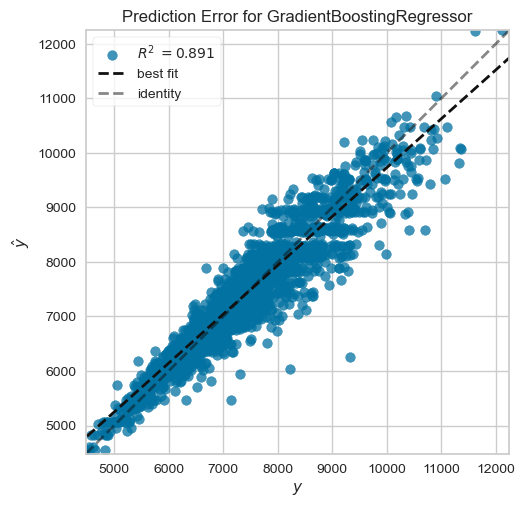

In [59]:
plot_model(best_model, plot='error')

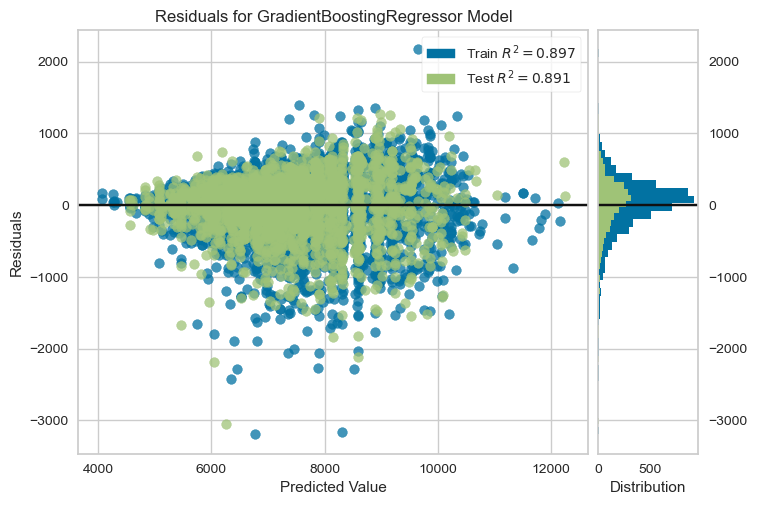

In [60]:
plot_model(best_model, plot='residuals')

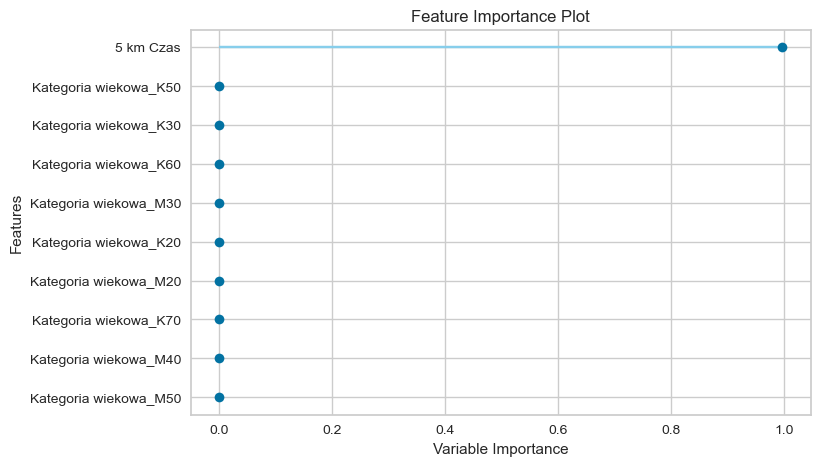

In [61]:
plot_model(best_model, plot='feature')

In [62]:
final_model = finalize_model(best_model)

In [63]:
save_model(final_model, 'hm_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['5 km Czas'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Płeć', 'Kategoria wiekowa'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=OrdinalEncoder(...
                                                                          'data_type': dtype('O'),
                                                                          'mapping': K      0
 M      1
 NaN   -1
 dtype: int64}]))),
                 ('onehot_encoding',
                  TransformerWrapper(include=['Kategoria wiekowa'],
                                     transformer=OneHotEncoder(cols=['Kategoria '
   